## Importing Libraries and Dataset

In [1]:
import csv, sys
csv.field_size_limit(sys.maxsize)

131072

In [2]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/data.csv',sep='§')

Mounted at /content/drive


<ipython-input-2-2451046378>:5: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('/content/drive/MyDrive/data.csv',sep='§')


In [3]:
import re
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

from xgboost import XGBClassifier

## Boosting

### Implementing XGBoost

In [ ]:
# classification with XGBoost
df = df[df['Level'].isin(['High', 'Medium', 'Low'])]
df['Level'] = df['Level'].astype(str)

# 1 new features
# 1.1 emails from 20 pm to 6 am
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['hour'] = df['Date'].dt.hour
df['is_night'] = df['hour'].apply(lambda x: 1 if x >= 20 or x < 6 else 0)

# 1.2 num_recipients
df['num_recipients'] = df['To'].fillna('').apply(lambda x: len(x.split(',')) if x else 0)

# 1.3 Emails sent to executives (To_External == False & Level == ‘High’)
df['to_executive'] = ((df['To_External'] == False) & (df['Level'] == 'High')).astype(int)

# 1.4 dummy for verbosity
df['verbosity'] = df['verbosity'].astype(str)  # assicurati che sia stringa
verbosity_dummies = pd.get_dummies(df['verbosity'], prefix='verbosity')
df = pd.concat([df, verbosity_dummies], axis=1)
df = df.drop(columns=['verbosity'])

numeric_cols = [
    'char_length', 'word_length', 'avg_word_length',
    'mtld', 'mattr',
    'is_night', 'num_recipients', 'to_executive'
] + verbosity_dummies.columns.tolist()


def add_keyword_features(df):
    Courtesy = ['please', 'thanks', 'thank', 'regards', 'sincerely', 'appreciate', 'best']
    Orders = ['confirm', 'forward', 'schedule', 'prepare', 'submit', 'review', 'organize', 'must', 'fix', 'should']
    Crisis = ['crisis', 'issue', 'problem', 'concern', 'urgent', 'delay', 'fail', 'risk', 'pressure']

    # keyword group
    def keyword_flag(df, keyword_list, group_name):
        pattern = r'\b(?:' + '|'.join(map(re.escape, keyword_list)) + r')\b'
        col_name = f'has_{group_name}'
        df[col_name] = df['Cleaned_Body_n'].str.contains(pattern, case=False, na=False).astype(int)
        return col_name

    new_cols = []
    new_cols.append(keyword_flag(df, Courtesy, 'courtesy'))
    new_cols.append(keyword_flag(df, Orders, 'orders'))
    new_cols.append(keyword_flag(df, Crisis, 'crisis'))

    return new_cols

keyword_feature_cols = add_keyword_features(df)
numeric_cols += keyword_feature_cols

# to numeric (in order to avoid errors)
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 2 Stratified Split: 2/3 train, 1/3 test
train_df, test_df = train_test_split(df, test_size=1/3, random_state=42, stratify=df['Level'])

X_train_text = train_df['Cleaned_Body_n'].fillna('')
X_test_text = test_df['Cleaned_Body_n'].fillna('')
y_train = train_df['Level']
y_test = test_df['Level']

X_train_numeric = train_df[numeric_cols]
X_test_numeric = test_df[numeric_cols]

# 3 preprocessing: TF-IDF + scaling
tfidf = TfidfVectorizer(max_features=1000)

# 4 pipeline
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

# 5 combine with ColumnTransformer
preprocessor = ColumnTransformer([
    ("tfidf", tfidf, "text"),
    ("num", numeric_transformer, numeric_cols)
])

X_train_all = train_df[numeric_cols].copy()
X_test_all = test_df[numeric_cols].copy()
X_train_all['text'] = X_train_text
X_test_all['text'] = X_test_text


In [ ]:
from sklearn.utils.class_weight import compute_sample_weight

# 6 XGBoost
model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", XGBClassifier(
        objective='multi:softmax',
        num_class=3,
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=42
    ))
])

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# 7 compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_enc)

# 8 fit
model.fit(X_train_all, y_train_enc, clf__sample_weight=sample_weights)
y_pred_enc = model.predict(X_test_all)

y_pred = le.inverse_transform(y_pred_enc)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:21:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

        High       0.68      0.91      0.77     14688
         Low       0.79      0.68      0.73     42888
      Medium       0.65      0.67      0.66     31682

    accuracy                           0.72     89258
   macro avg       0.71      0.75      0.72     89258
weighted avg       0.72      0.72      0.71     89258



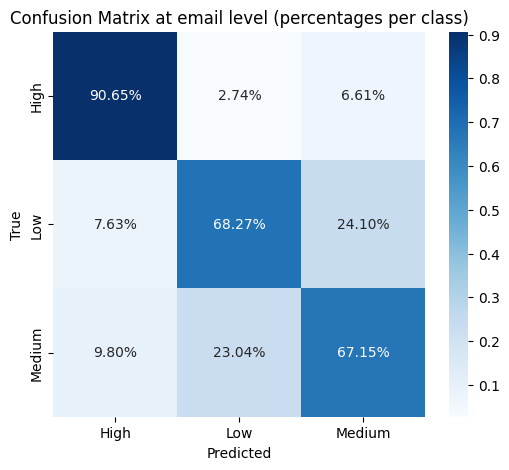

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix
cm_email = confusion_matrix(y_test, y_pred, labels=le.classes_)
cm_email_norm = cm_email.astype('float') / cm_email.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_email_norm,
    annot=True,
    fmt='.2%',
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix at email level (percentages per class)")
plt.show()


### Feature importance for XGBoost

In [ ]:
# XGBoost booster
clf = model.named_steps["clf"]
booster = clf.get_booster()
importance_dict = booster.get_score(importance_type='gain')

numeric_features = numeric_cols
tfidf_features = list(preprocessor.named_transformers_['tfidf'].get_feature_names_out())
all_features = numeric_features + tfidf_features

mapped_importance = {
    all_features[int(f[1:])]: v for f, v in importance_dict.items()
    if int(f[1:]) < len(all_features)
}

# TF-IDF vs. others
final_importance = {}
tfidf_total = 0

for feat, score in mapped_importance.items():
    if feat in tfidf_features:
        tfidf_total += score
    else:
        final_importance[feat] = score

# aggregate TF-IDF
final_importance['tfidf'] = tfidf_total

# sort by importance
sorted_importance = sorted(final_importance.items(), key=lambda x: x[1], reverse=True)
for feat, score in sorted_importance:
    print(f"{feat:30} {score:.4f}")


tfidf                          14315.8889
verbosity_verbose              18.9240
num_recipients                 9.8446
verbosity_normal               9.8108
is_night                       9.7104
has_orders                     5.7812
mtld                           5.5649
has_courtesy                   5.5025
has_crisis                     5.3319
avg_word_length                4.8401
to_executive                   4.3876
mattr                          3.4388
word_length                    2.9600
verbosity_concise              0.2865


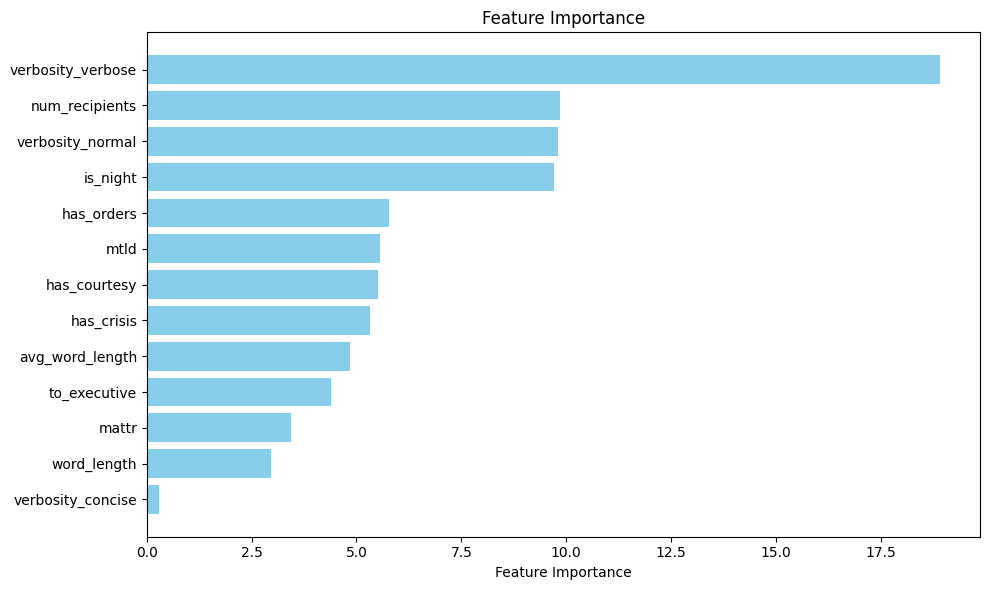

In [ ]:
# filter features, excluding 'tfidf'
filtered_importance = {feat: score for feat, score in final_importance.items() if feat != 'tfidf'}

# sort
sorted_items = sorted(filtered_importance.items(), key=lambda x: x[1], reverse=True)
features, scores = zip(*sorted_items)

# plot
plt.figure(figsize=(10, 6))
plt.barh(features, scores, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Support Vector Machine

In [ ]:
import csv, sys
csv.field_size_limit(sys.maxsize)

9223372036854775807

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv(
    '/content/drive/MyDrive/NLP_Project/data.csv',
    sep='§')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-10-2427763287>:5: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(


In [ ]:
# classification with Support Vector Machine
df = df[df['Level'].isin(['High', 'Medium', 'Low'])]
df['Level'] = df['Level'].astype(str)

# 1 new features
# 1.1 emails from 20 pm to 6 am
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['hour'] = df['Date'].dt.hour
df['is_night'] = df['hour'].apply(lambda x: 1 if x >= 20 or x < 6 else 0)

# 1.2 num_recipients
df['num_recipients'] = df['To'].fillna('').apply(lambda x: len(x.split(',')) if x else 0)

# 1.3 Emails sent to executives (To_External == False & Level == ‘High’)
df['to_executive'] = ((df['To_External'] == False) & (df['Level'] == 'High')).astype(int)

# 1.4 dummy for verbosity
df['verbosity'] = df['verbosity'].astype(str)  # assicurati che sia stringa
verbosity_dummies = pd.get_dummies(df['verbosity'], prefix='verbosity')
df = pd.concat([df, verbosity_dummies], axis=1)
df = df.drop(columns=['verbosity'])

numeric_cols = [
    'char_length', 'word_length', 'avg_word_length',
    'mtld', 'mattr',
    'is_night', 'num_recipients', 'to_executive'
] + verbosity_dummies.columns.tolist()


def add_keyword_features(df):
    Courtesy = ['please', 'thanks', 'thank', 'regards', 'sincerely', 'appreciate', 'best']
    Orders = ['confirm', 'forward', 'schedule', 'prepare', 'submit', 'review', 'organize', 'must', 'fix', 'should']
    Crisis = ['crisis', 'issue', 'problem', 'concern', 'urgent', 'delay', 'fail', 'risk', 'pressure']

    # keyword group
    def keyword_flag(df, keyword_list, group_name):
        pattern = r'\b(?:' + '|'.join(map(re.escape, keyword_list)) + r')\b'
        col_name = f'has_{group_name}'
        df[col_name] = df['Cleaned_Body_n'].str.contains(pattern, case=False, na=False).astype(int)
        return col_name

    new_cols = []
    new_cols.append(keyword_flag(df, Courtesy, 'courtesy'))
    new_cols.append(keyword_flag(df, Orders, 'orders'))
    new_cols.append(keyword_flag(df, Crisis, 'crisis'))

    return new_cols

keyword_feature_cols = add_keyword_features(df)
numeric_cols += keyword_feature_cols

# to numeric (in order to avoid errors)
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 2 Stratified Split: 2/3 train, 1/3 test
train_df, test_df = train_test_split(df, test_size=1/3, random_state=42, stratify=df['Level'])

X_train_text = train_df['Cleaned_Body_n'].fillna('')
X_test_text = test_df['Cleaned_Body_n'].fillna('')
y_train = train_df['Level']
y_test = test_df['Level']

X_train_numeric = train_df[numeric_cols]
X_test_numeric = test_df[numeric_cols]

# 3 preprocessing: TF-IDF + scaling
tfidf = TfidfVectorizer(max_features=1000)

# 4 pipeline
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

# 5 combine with ColumnTransformer
preprocessor = ColumnTransformer([
    ("tfidf", tfidf, "text"),
    ("num", numeric_transformer, numeric_cols)
])

X_train_all = train_df[numeric_cols].copy()
X_test_all = test_df[numeric_cols].copy()
X_train_all['text'] = X_train_text
X_test_all['text'] = X_test_text

In [ ]:
model_svm = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LinearSVC(class_weight='balanced', random_state=42, max_iter=10000))
])

# label encoding del target
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# compute weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_enc)

# fit with sample_weight
model_svm.fit(X_train_all, y_train_enc, clf__sample_weight=sample_weights)

y_pred_enc_svm = model_svm.predict(X_test_all)
y_pred_svm = le.inverse_transform(y_pred_enc_svm)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

        High       0.60      0.91      0.72     14688
         Low       0.78      0.54      0.64     42888
      Medium       0.57      0.68      0.62     31682

    accuracy                           0.65     89258
   macro avg       0.65      0.71      0.66     89258
weighted avg       0.68      0.65      0.65     89258



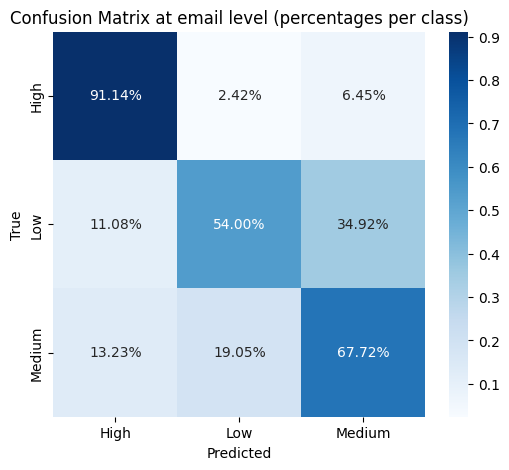

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix
cm_email = confusion_matrix(y_test, y_pred_svm, labels=le.classes_)
cm_email_norm = cm_email.astype('float') / cm_email.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_email_norm,
    annot=True,
    fmt='.2%',
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix at email level (percentages per class)")
plt.show()